# Disciplina de Tópicos em Inteligencia Computacional

### Imports Bibliotecas Importantes

In [1]:
# inline plotting instead of popping out
%matplotlib inline

import os, math
from IPython.display import Image
import numpy as np
seed = np.random.seed

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Carregando Base de Dados

Neste exemplo será utilizada a base de dados Iris. O modelo Perceptron foi originalmente projetado para problemas de classificação binária. No entanto, utilizando bibliotecas como o Scikit-learn é capaz de prever os rótulos de várias classes (3 neste caso). Nos exemplos abaixo serão uitilizadas apenas 2 classes para tornar os modelos capazes de resolver problemas linearmente separáveis.

In [2]:
df = pd.read_csv('/data/dataset/Iris/iris.data',
    header = None
)
df = df.drop(index=0)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]



,Sepal length,Sepal width,Petal length,Petal width,Class label
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


Logo abaixo é feita a conversão da base original em duas classes.

In [3]:
X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

#display(X)
#display(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))

#Training data points: 90
#Testing data points: 10
Class labels: [-1  1]


### Normalização dos Dados

O gradiente descendente pode ter um desempenho ruim se o Hessiano da função f a ser minimizado tem um grande número de condições. Neste caso, a superfície de f pode ser curvo em algumas direções, mas plano em outras. Portanto, o gradiente descendente, que ignora as curvaturas, pode ultrapassar o ponto ideal ao longo das direções curvas, mas dar um passo muito pequeno nas direções planas.

OBS: Se essa parte do código abaixo não for realizada, a taxa de acurácia de todos os modelos treinados neste notebook caem para baixo de 40%

Uma maneira comum de melhorar o condicionamento de f é padronizar conjunto de dados x, do seguinte modo:

In [4]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

## Perceptron Scikit-Learn

Abaixo é feito um experimento utilizando a biblioteca do Scikit-Learn, apesar do resultado semelhante aos dos outros modelos, este Perceptron é capaz de resolver problemas não linearmente separáveis.

In [5]:
ppn = Perceptron(max_iter=10, eta0=0.1, random_state=0)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, max_iter=10)

In [6]:
y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Misclassified samples: 2
Accuracy: 0.80


## Implementação Perceptron

Abaixo a implementação do Perceptron normal sem a utilização da biblioteca Scikit-Learn

In [7]:
class Perceptron2(object):
    """Perceptron classifier.
    
    Parameters
    ------------
    eta: float 
        Learning rate (between 0.0 and 1.0)
    n_iter: int
        Number of epochs, i.e., passes over the training dataset.
        
    Attributes
    ------------
    w_: 1d-array
        Weights after fitting.
    errors_: list
        Number of misclassifications in every epoch.
    random_state : int
        The seed of the pseudo random number generator.
    """
    
    def __init__(self, eta=0.01, n_iter=10, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values, or labels.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.errors_ = []
        
        for _ in range(self.n_iter):
            errors = 0.0
            for xi, yi in zip(X, y):
                output = self.predict(xi)
                error = (yi - output)
                self.w_[1:] += self.eta * error * xi
                self.w_[0] += self.eta * error
                errors += int(error != 0.0)
            self.errors_.append(errors)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

OBS: 

Poderíamos ter implementado a versão abreviada de x e W para incluir o termo de viés (bias). No entanto, destacamos a adição do termo de viés (self.w_[0]) por motivos de desempenho, pois ao adicionar um vetor de 1 ao array de treinamento toda vez que queremos fazer uma previsão seria ineficiente.

Algumas implementações de produção embaralham os dados no início de cada época. Esta etapa é omitida para simplificar.

Para treinar o modelo Perceptron binário usando o conjunto de dados Iris, recriamos nossos conjuntos de treinamento e teste para que contenham apenas rótulos binários:

In [8]:
# training

ppn2 = Perceptron2(eta=0.1, n_iter=20)

ppn2.fit(X_train_std, y_train)

# testing

y_pred = ppn2.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Misclassified samples: 3
Accuracy: 0.70


Nosso modelo Perceptron atinge 70% de precisão, o que não é muito bom. Isso ocorre principalmente porque o algoritmo de treinamento não converge quando os pontos de dados não são separáveis linearmente (por um hiperplano).

## Função que Implementa Perceptro Adaline com Gradiente Descendente

O ADaptive LInear NEuron (Adaline) é semelhante ao Perceptron, exceto que ele define uma função de custo baseada no soft output e um problema de otimização. Podemos, portanto, aproveitar várias técnicas de otimização para treinar Adaline de uma maneira mais teórica. Vamos implementar o Adaline usando o algoritmo de gradiente descendente (GD) em lote:

In [9]:
class AdalineGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int
        The seed of the pseudo random number generator.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values or labels.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.activation(X)
            
            # Cost function
            error = (y - output)
            cost = (error**2).sum() / 2.0
            self.cost_.append(cost)
            
            # Update rule
            self.w_[1:] += self.eta * X.T.dot(error)
            self.w_[0] += self.eta * error.sum()
            
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

Uma boa taxa de aprendizado (η) é a chave para a convergência ótima. Na prática, muitas vezes requer alguma experimentação para encontrar uma boa taxa de aprendizado. Vamos plotar o custo em relação ao número de épocas para as duas taxas de aprendizado diferentes:

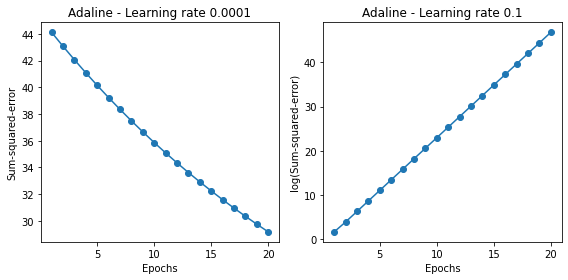

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ada1 = AdalineGD(n_iter=20, eta=0.0001).fit(X_train_std, y_train)
ax[0].plot(range(1, len(ada1.cost_) + 1), ada1.cost_, marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Sum-squared-error')
ax[0].set_title('Adaline - Learning rate 0.0001')

ada2 = AdalineGD(n_iter=20, eta=0.1).fit(X_train_std, y_train)
ax[1].plot(range(1, len(ada2.cost_) + 1), np.log10(ada2.cost_), marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('log(Sum-squared-error)')
ax[1].set_title('Adaline - Learning rate 0.1')

plt.tight_layout()
plt.savefig('./fig-adaline-gd-overshoot.png', dpi=300)
plt.show()

A figura à esquerda mostra o que pode acontecer se escolhermos uma taxa de aprendizado muito pequena: embora o custo diminua, a descida é muito pequena para que o algoritmo exija um grande número de épocas para convergir. Por outro lado, a figura da direita mostra o que pode acontecer se escolhermos uma taxa de aprendizado muito grande: em vez de minimizar a função de custo, o erro se torna maior a cada época porque ultrapassamos o ponto ótimo todas as vezes.

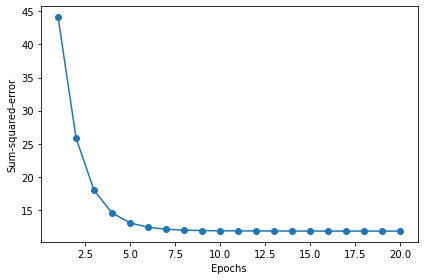

Misclassified samples: 2
Accuracy: 0.80


In [11]:
ada = AdalineGD(n_iter=20, eta=0.01)
ada.fit(X_train_std, y_train)

# cost values

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
plt.savefig('./fig-adalin-gd-cost.png', dpi=300)
plt.show()

# testing accuracy

y_pred = ada.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))



Com uma taxa de aprendizagem devidamente escolhida η, o AdalineGD converge e oferece uma melhor precisão de previsão (80%) em comparação com o Perceptron (70%):

## Função que Implementa Perceptro Adaline com Gradiente Descendente Estocástico

Executar a descida do gradiente pode ser computacionalmente custoso quando o número de exemplos N em um conjunto de dados de treinamento é grande, pois precisamos varrer todo o conjunto de dados toda vez para dar um passo de descida. A descida do gradiente estocástico (SGD) atualiza os pesos de forma incremental para cada minilote de tamanho M, M≪N. O SGD geralmente atinge a convergência muito mais rapidamente devido às atualizações de peso mais frequentes. Como cada gradiente é calculado com base em poucos exemplos de treinamento, o ponto tomado em cada etapa pode "vagar" aleatoriamente e o valor do custo nem sempre diminui. No entanto, isso pode ser considerado uma vantagem, pois pode escapar de mínimos locais rasos quando a função de custo não é convexa. Para evitar que o SGD se desvie do ponto ideal, geralmente substituímos a taxa de aprendizado constante η por uma taxa de aprendizagem adaptativa que diminui ao longo do tempo.


In [12]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state : seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values or labels.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, yi in zip(X, y):
                cost.append(self._update_weights(xi, yi))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, yi):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(xi)
        
        # Cost function
        error = (yi - output)
        cost = 0.5 * error**2
        
        # Update rule
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, yi in zip(X, y):
                self._update_weights(xi, yi)
        else:
            self._update_weights(X, y)
        return self

Vamos ver como Adaline se sai com SGD:

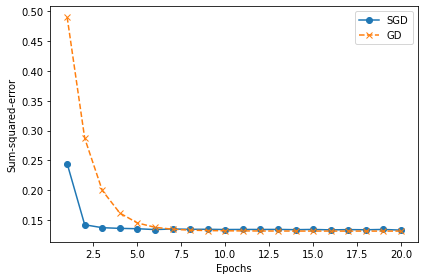

Misclassified samples: 2
Accuracy: 0.80


In [13]:
adas = AdalineSGD(n_iter=20, eta=0.01, random_state=1)
adas.fit(X_train_std, y_train)

# Cost values
plt.plot(range(1, len(adas.cost_) + 1), adas.cost_, 
         marker='o', label='SGD')
plt.plot(range(1, len(ada.cost_) + 1), np.array(ada.cost_) / len(y_train), 
         marker='x', linestyle='--', label='GD')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('./fig-adaline-sgd-cost.png', dpi=300)
plt.show()

# Testing accuracy
y_pred = adas.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Como podemos ver, o valor do custo diminui rapidamente e é apenas ligeiramente pior do que o valor do custo (normalizado) da descida do gradiente do lote após 7 épocas.

Outra vantagem do gradiente descendente estocástico é que podemos usá-lo para aprendizado online. No aprendizado on-line, um modelo é treinado em tempo real à medida que novos dados de treinamento chegam. Isso é especialmente útil se estivermos acumulando grandes quantidades de dados ao longo do tempo. Por exemplo, dados de clientes em aplicativos da Web. Usando o aprendizado online, o sistema pode se adaptar imediatamente às mudanças sem treinar do zero. Além disso, se o espaço de armazenamento for um problema, podemos descartar os dados de treinamento após atualizar o modelo.